# Alpha Analysis - electron lifetime, channel calibration, charge yield

In [13]:
from TMSAnalysis.StruckAnalysisConfiguration import StruckAnalysisConfiguration
from TMSAnalysis.TMSUtilities.GetCuts import Cut
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time,copy

plt.rcParams['figure.figsize'] = [10, 8]
plt.rcParams['font.size'] = 15

path_to_reduced = '/p/lustre1/jacopod/30th/'
folder = '20200917_Night_AfterThirdRnInjection/analysis_500ns'
analysis_config = StruckAnalysisConfiguration.StruckAnalysisConfiguration()
analysis_config.GetRunParametersFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx',folder)
analysis_config.GetCalibrationConstantsFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run11b.csv')
analysis_config.GetChannelMapFromFile('/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx',folder)
sampling_time = analysis_config.run_parameters['Sampling Period [ns]']/1.e3
trigger_time = analysis_config.run_parameters['Pretrigger Length [samples]']

In [14]:
start_time = time.time()
df = pd.read_pickle(path_to_reduced + folder + '/reduced_added.p')
print('dataframe with {} events loaded in {:.1f}s'.format(df.shape[0],time.time() - start_time))
DriftTime = (df['TimeOfMaxChannel'] - trigger_time)*sampling_time
for k in df.keys():
    print(k)

dataframe with 2232041 events loaded in 96.3s
ChannelPositions
ChannelTypes
Cluster Drift Time
Cluster Energies
Cluster X-Pos
Cluster Y-Pos
Cluster Z-Pos
Event
File
IsFull3D
NumSiPMChannelsHit
NumTileChannelsHit
NumXTileChannelsHit
NumYTileChannelsHit
Number3DClusters
NumberOfClusters
SiPM 1-1 Baseline
SiPM 1-1 Baseline RMS
SiPM 1-1 Induced Charge
SiPM 1-1 Pulse Area
SiPM 1-1 Pulse Height
SiPM 1-1 Pulse Time
SiPM 1-1 T10
SiPM 1-1 T20
SiPM 1-1 T5
SiPM 1-1 T80
SiPM 1-1 T90
SiPM 1-2 Baseline
SiPM 1-2 Baseline RMS
SiPM 1-2 Induced Charge
SiPM 1-2 Pulse Area
SiPM 1-2 Pulse Height
SiPM 1-2 Pulse Time
SiPM 1-2 T10
SiPM 1-2 T20
SiPM 1-2 T5
SiPM 1-2 T80
SiPM 1-2 T90
SiPM 1-3 Baseline
SiPM 1-3 Baseline RMS
SiPM 1-3 Induced Charge
SiPM 1-3 Pulse Area
SiPM 1-3 Pulse Height
SiPM 1-3 Pulse Time
SiPM 1-3 T10
SiPM 1-3 T20
SiPM 1-3 T5
SiPM 1-3 T80
SiPM 1-3 T90
SiPM 1-4 Baseline
SiPM 1-4 Baseline RMS
SiPM 1-4 Induced Charge
SiPM 1-4 Pulse Area
SiPM 1-4 Pulse Height
SiPM 1-4 Pulse Time
SiPM 1-4 T10
SiPM 

Text(0, 0.5, 'ADC Counts')

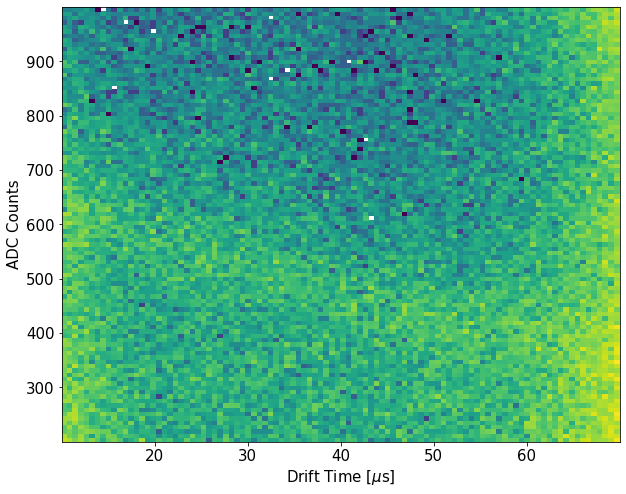

In [15]:
min_time = 10
max_time = 70
mask = (df['TotalTileEnergy']<1000) & (df['TotalTileEnergy']>200)\
& (DriftTime<max_time) & (DriftTime>min_time) & (df['NumberOfClusters']<3)
plt.hist2d(DriftTime[mask], df['TotalTileEnergy'][mask], bins=100, norm=LogNorm())
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('ADC Counts')
#plt.colorbar()

## Electron lifetime

In [16]:
def fit_function(x, A, beta, B, mu, sigma):
    return (A * np.exp(-x/beta) +\
            B * np.exp(-1.0 * (x - mu)**2 / (2 * sigma**2)))
def exp_function(x, A, beta):
    return(A * np.exp(-x/beta))

slicing into ~10$\mu$s windows and fitting the alpha peak

[ 697.22415918 1012.10219694  141.81959264  593.05266098   52.43131923]


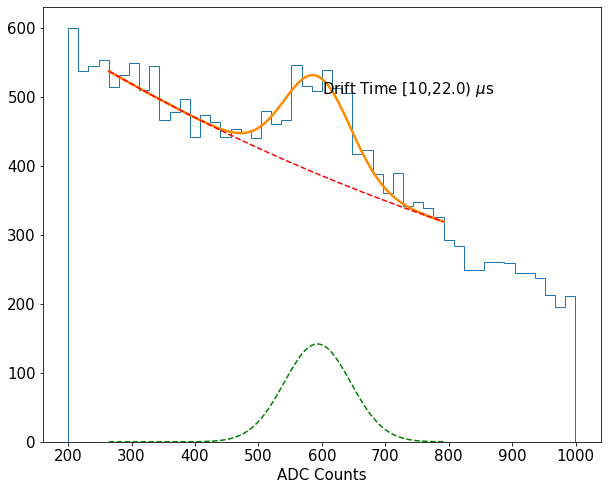

[ 548.11550925 1068.76974548  143.12801151  527.15438925   59.43195329]


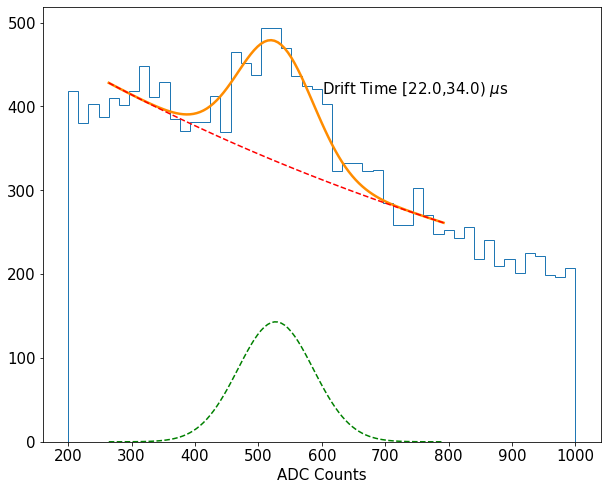

[590.66787383 817.77410557 137.91927507 463.8760323   61.10412633]


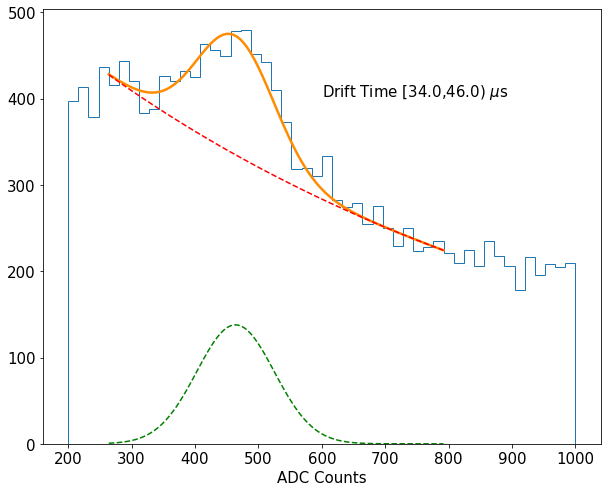

[662.3760478  800.         168.43392378 419.08661741  46.01860595]


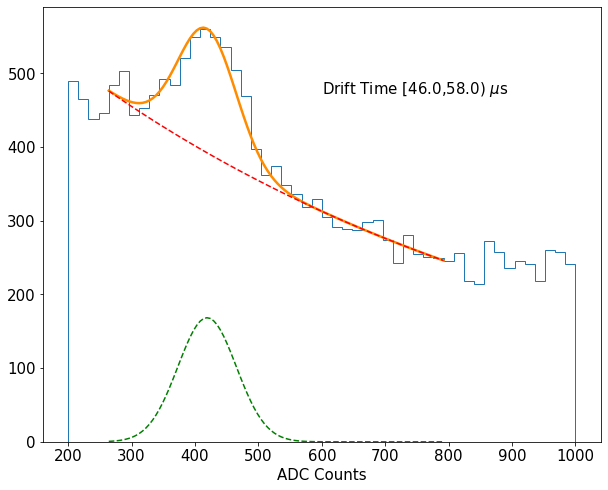

[ 745.562967   1600.          180.          365.42430442   70.83283966]


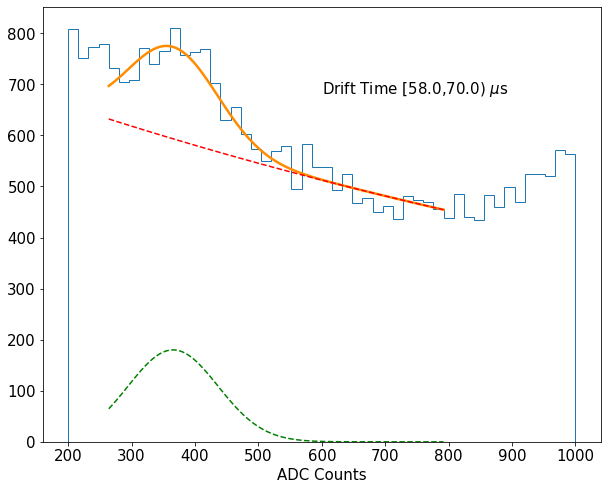

In [17]:
fit_data = {'time':[],'peak':[],'peak_error':[]}
p0 = ([None],[1000,800,150,600,40],[500,800,120,500,80],[600,2000,100,500,40],[600,4000,100,400,40],[900,8000,100,500,50])
slices = 6
for i,rg in enumerate(np.linspace(min_time,max_time,slices)):

    bins = 50
    fit_range = [250,800]
    if i == 0:
        rg_0 = min_time
        continue
    bounds = (np.asarray(p0[i])*0.2,np.asarray(p0[i])*1.8)
    #if i == slices - 1:
    #    fit_range = [250,600]
    #if i  == 3:
    #    bins = 100
    #    fit_range = [250,1000]
    #if i == slices-1:
    #    mask1 = np.logical_and(mask1,df['NumTileChannelsHit']==1)
    #    fit_range = [350,550]
    #    bins = 80
    #    bounds[0][1] = p0[i][1]*1.8
    #    bounds[1][1] = p0[i][1]*0.2

    mask1 = mask & (DriftTime<rg) & (DriftTime>rg_0)
    data, bin_edges,_ = plt.hist(df['TotalTileEnergy'][mask1],bins=bins,histtype='step')
    bin_width = bin_edges[1]-bin_edges[0]
    fit_idx = np.where((bin_edges>fit_range[0]) & (bin_edges<fit_range[1]))[0]
    popt, pcov = curve_fit(fit_function, xdata=bin_edges[fit_idx], ydata=data[fit_idx],p0=p0[i],bounds=bounds)
    print(popt)
    fit_x_bin = np.linspace(bin_edges[fit_idx][0],bin_edges[fit_idx][-1],100)
    plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
    popt_buffer = copy.deepcopy(popt)
    for ix,j in zip((0,2),('green','red')):
        popt[ix] = 0
        plt.plot(fit_x_bin, fit_function(fit_x_bin, *popt), color=j, linewidth=1.5,linestyle='dashed')
        popt = copy.deepcopy(popt_buffer)
    plt.text(0.5, 0.8, 'Drift Time [{},{}) $\mu$s'.format(rg_0,rg), transform = plt.gca().transAxes)
    plt.xlabel('ADC Counts')
    plt.show()
    fit_data['time'].append((rg + rg_0)/2)
    fit_data['peak'].append(popt[3])
    fit_data['peak_error'].append(np.sqrt(pcov[3,3]) + np.sqrt(popt[3]*bin_width/(popt[2]*np.sqrt(2*np.pi))))
    rg_0 = rg
    
fit_data = pd.DataFrame(fit_data)

Text(0.4, 0.7, 'A = 693.4$\\pm$6.6\n$\\tau$ = 101.8$\\pm$2.5$\\mu$s')

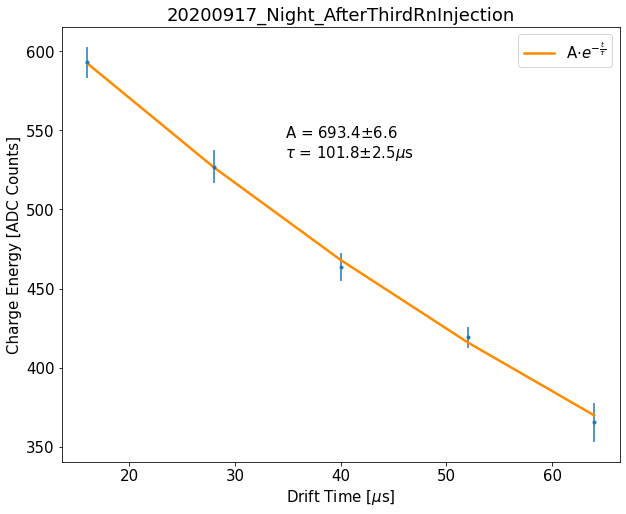

In [18]:
plt.errorbar(fit_data['time'],fit_data['peak'],fit_data['peak_error'],fmt='.')
popt_e, pcov_e = curve_fit(exp_function, xdata=fit_data['time'], ydata=fit_data['peak'],\
                       p0=(600,1000),sigma=fit_data['peak_error'])
text = 'A = {:.1f}$\pm${:.1f}'.format(popt_e[0],np.sqrt(np.diag(pcov_e))[0])+ '\n' +\
r'$\tau$ = {:.1f}$\pm${:.1f}$\mu$s'.format(popt_e[1],np.sqrt(np.diag(pcov_e))[1])
plt.plot(fit_data['time'], exp_function(fit_data['time'], *popt_e), color='darkorange', linewidth=2.5,\
         label=r'A$\cdot e^{-\frac{t}{\tau}}$')
plt.xlabel('Drift Time [$\mu$s]')
plt.ylabel('Charge Energy [ADC Counts]')
plt.title(folder.split('/')[0])
plt.legend()
plt.text(0.4, 0.7, text, transform = plt.gca().transAxes)

## Diffusion

here I apply the purity correction and cut on the SS events, it is possible to see (right plot) how the alpha peak is sharper with purity corrected energy, I'll use this quantity to look at the diffusion

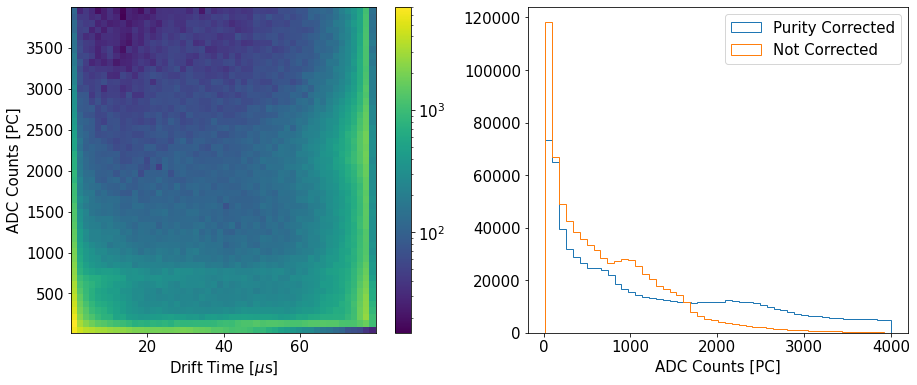

In [8]:
df['Purity-Corrected Charge Energy'] = df['TotalTileEnergy']*np.exp(DriftTime/popt_e[1])
mask = (df['Purity-Corrected Charge Energy']<4000) & (DriftTime>0) & (DriftTime<80) & (df['NumberOfClusters']<3)
fig,ax = plt.subplots(1,2,figsize=(15,6))
_,_,_,im = ax[0].hist2d(DriftTime[mask], df['Purity-Corrected Charge Energy'][mask], bins=50, norm=LogNorm())
ax[0].set_xlabel('Drift Time [$\mu$s]')
ax[0].set_ylabel('ADC Counts [PC]')
ax[1].hist(df['Purity-Corrected Charge Energy'][mask],bins=bins,histtype='step', label='Purity Corrected')
ax[1].hist(df['TotalTileEnergy'][mask],bins=bins,histtype='step', label='Not Corrected')
ax[1].legend()
ax[1].set_xlabel('ADC Counts [PC]')
fig.colorbar(im,ax=ax[0])

## Alpha calibration

The SC alphas can be used to calibrate each channel, first I run some sanuty check on each channel. Then I'll uncalibrate the channels (from the wrong calibration) and try to select the alpha peak for the new calibration

In [9]:
def merge_and_condition(array):
    mask = np.ones(np.shape(array[0]))
    for arr in array:
        mask = np.logical_and(mask,arr)
    return mask

Here I look for the alpha peak on the different channels by cutting for SC energy deposit with a quite tight (purity-corrected) energy range

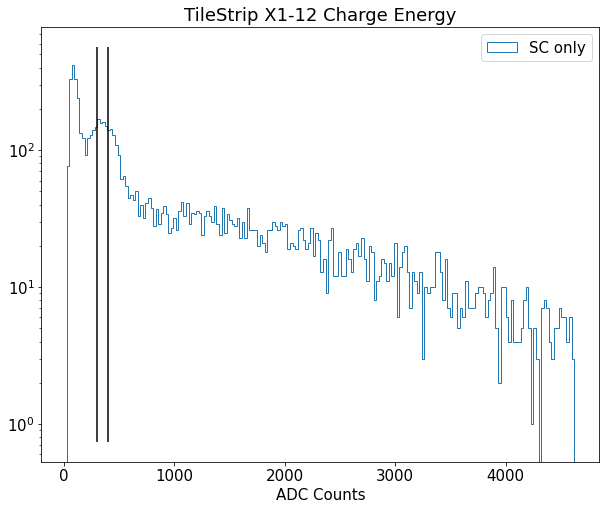

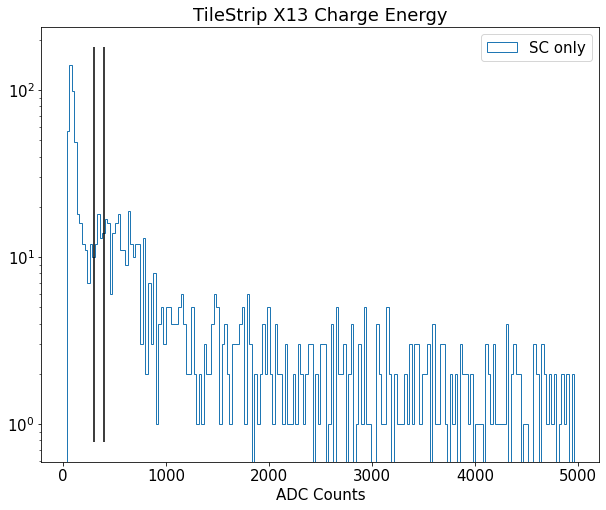

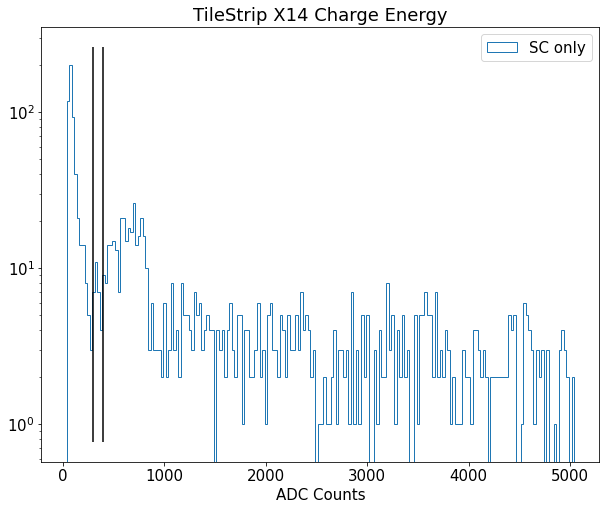

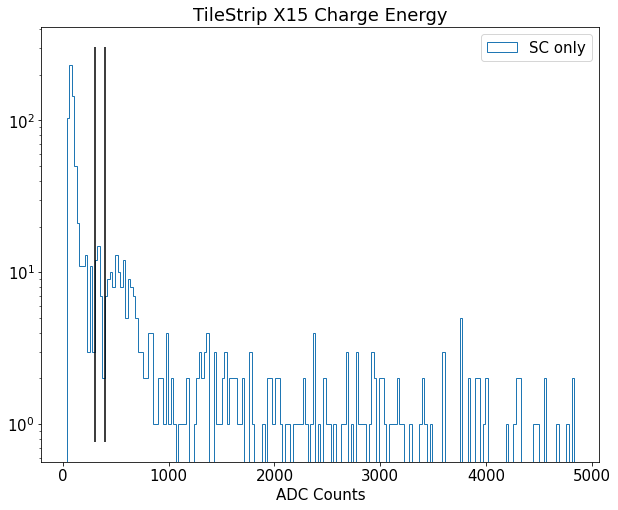

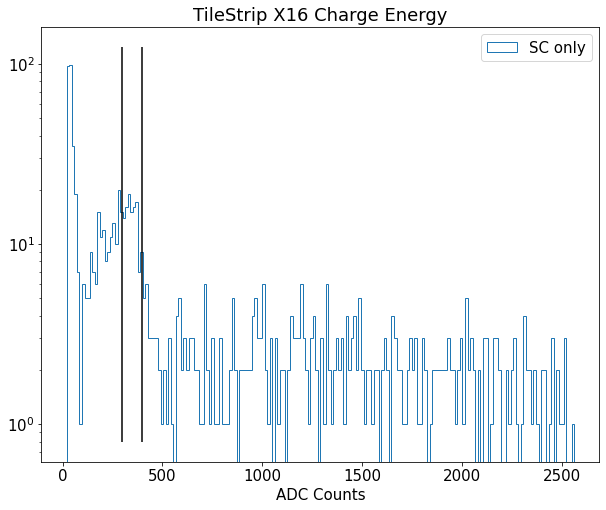

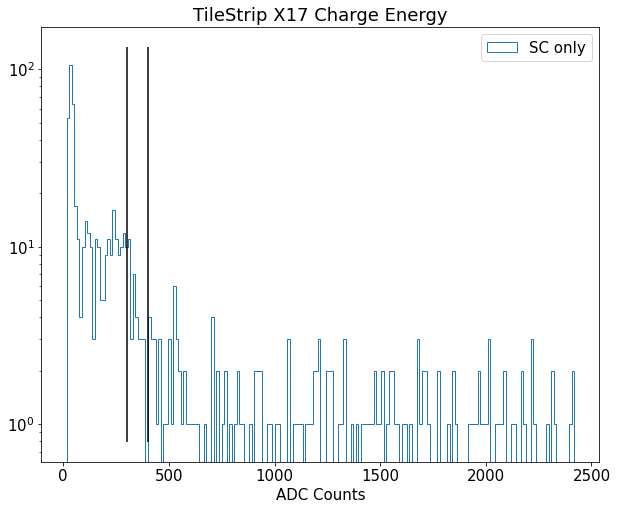

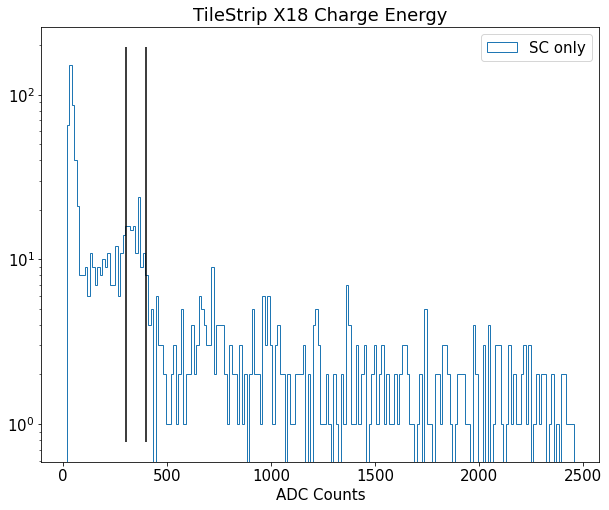

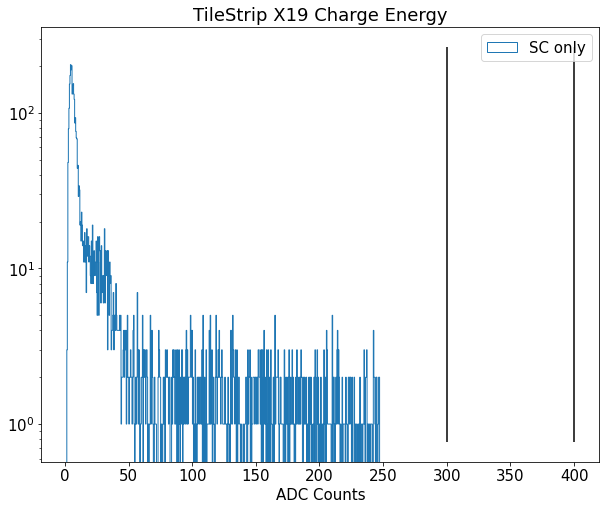

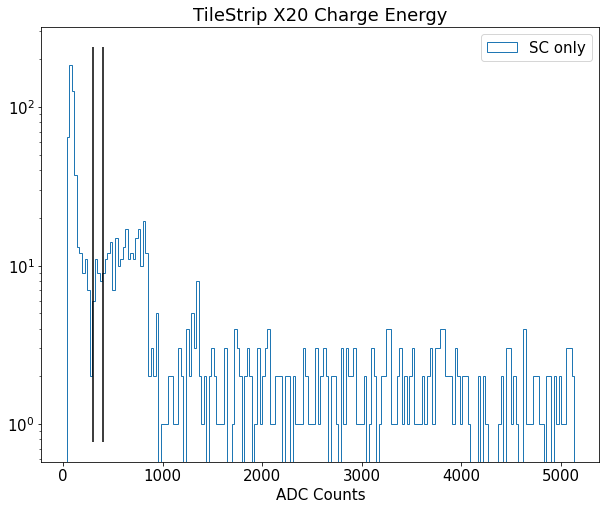

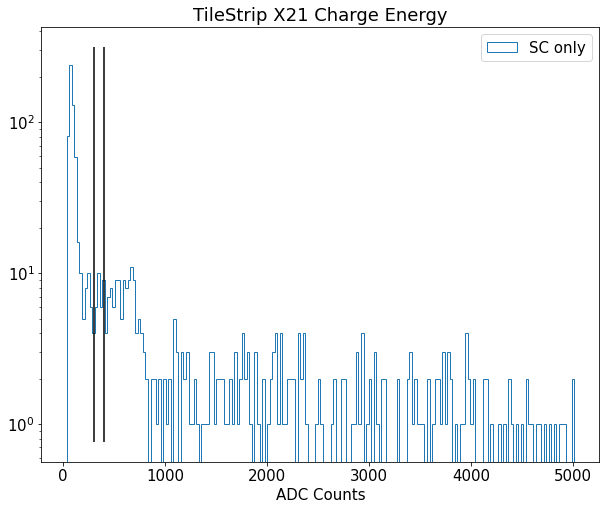

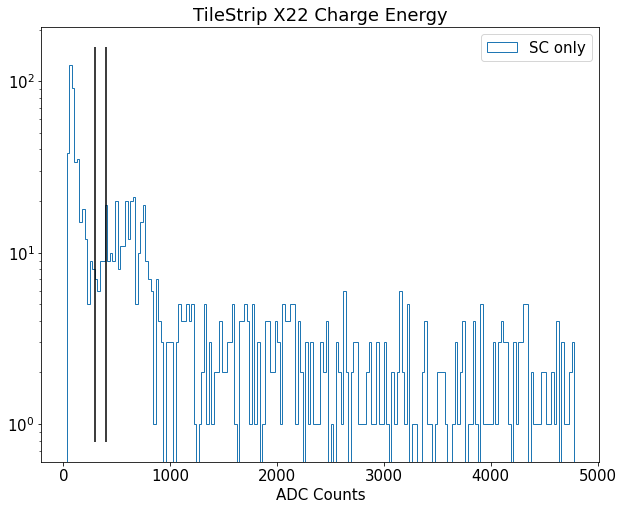

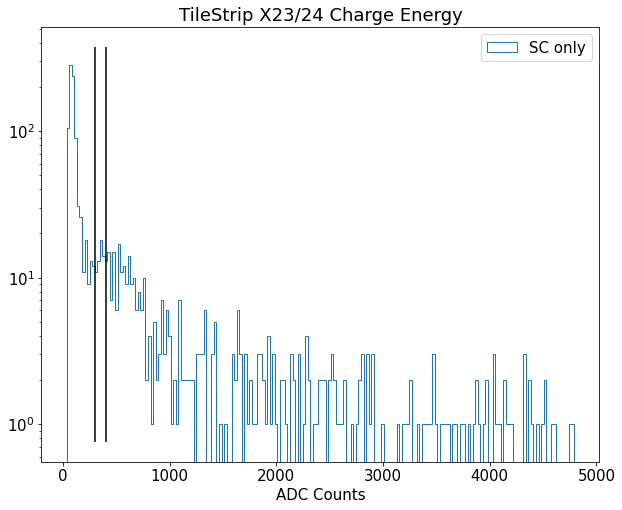

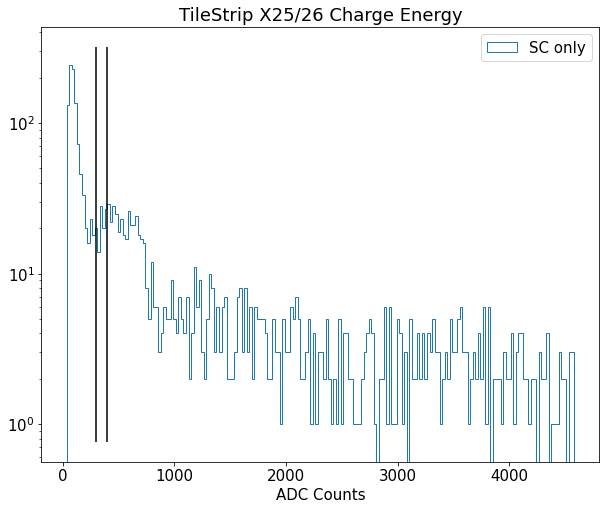

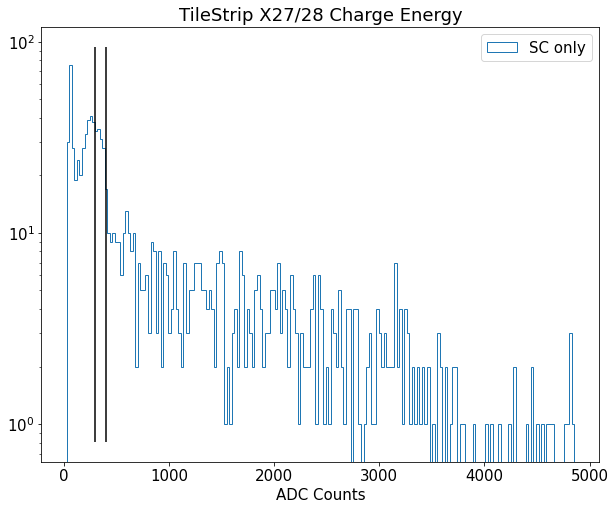

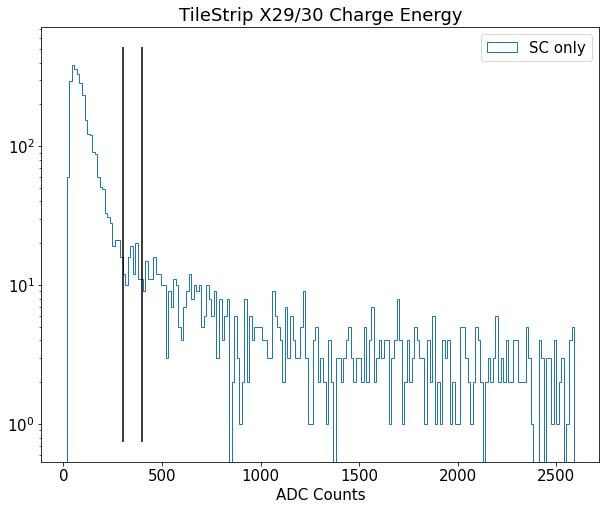

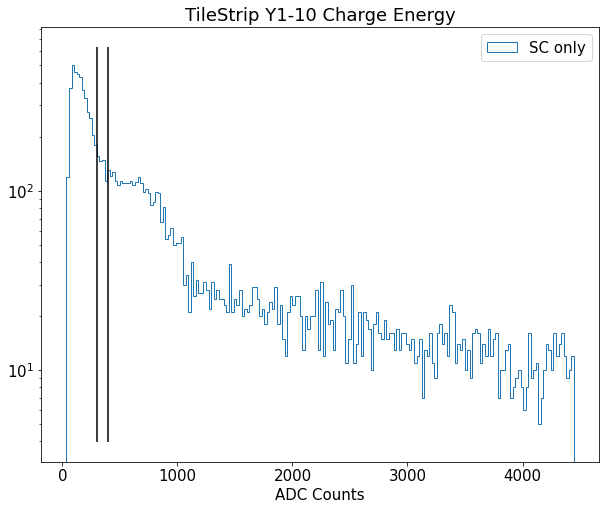

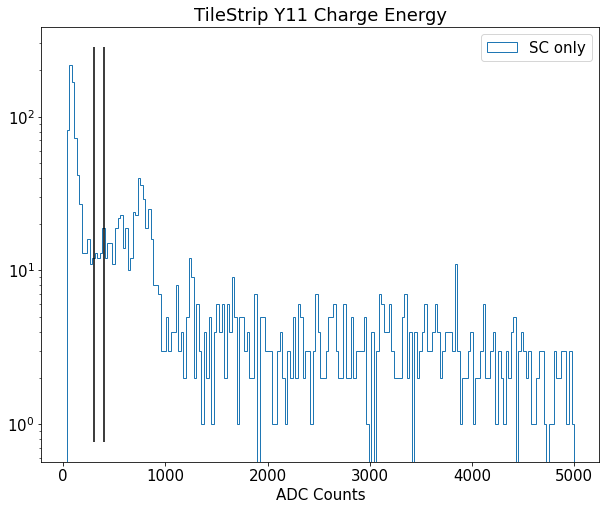

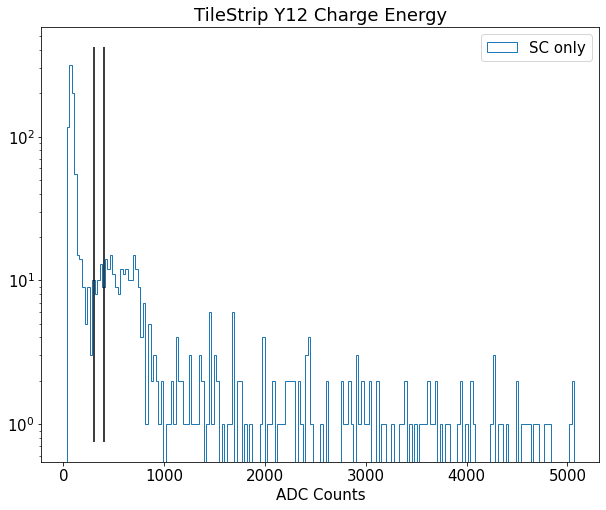

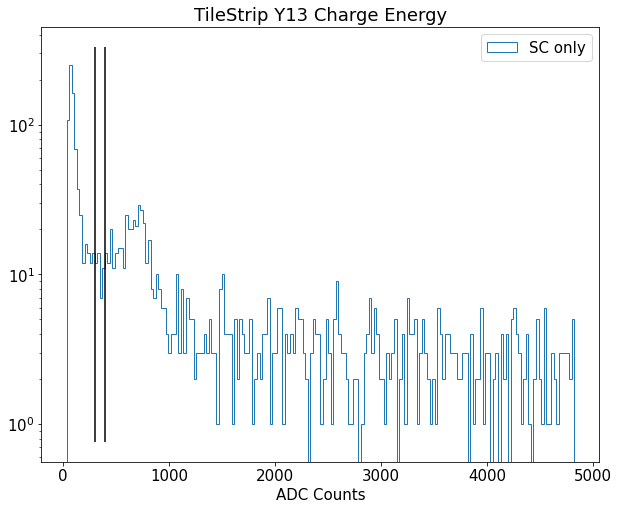

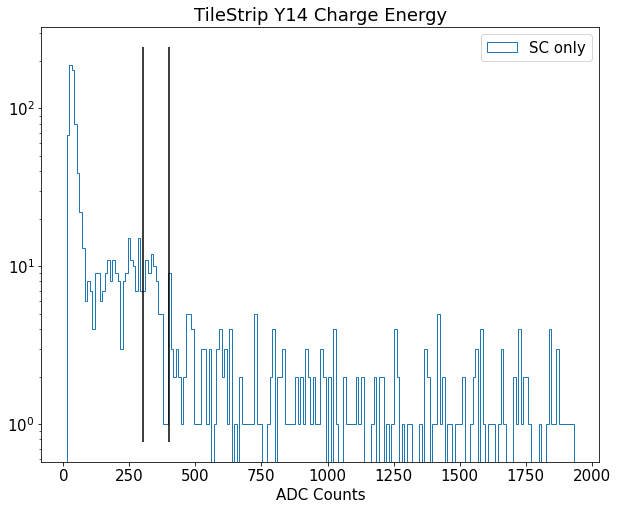

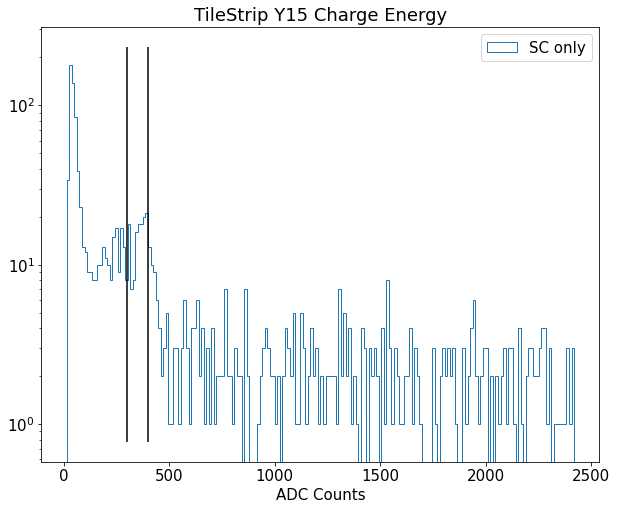

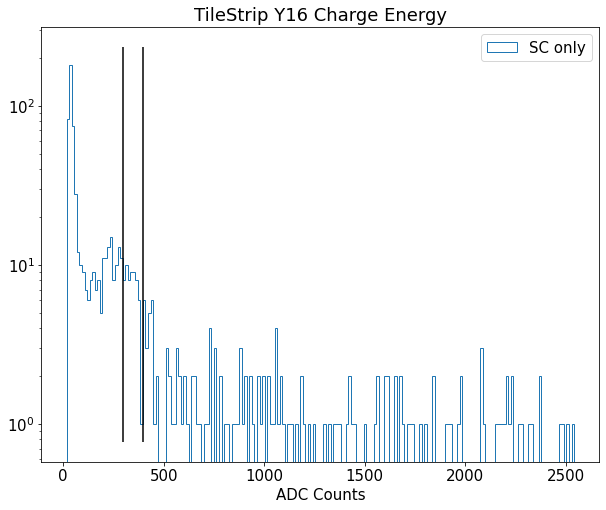

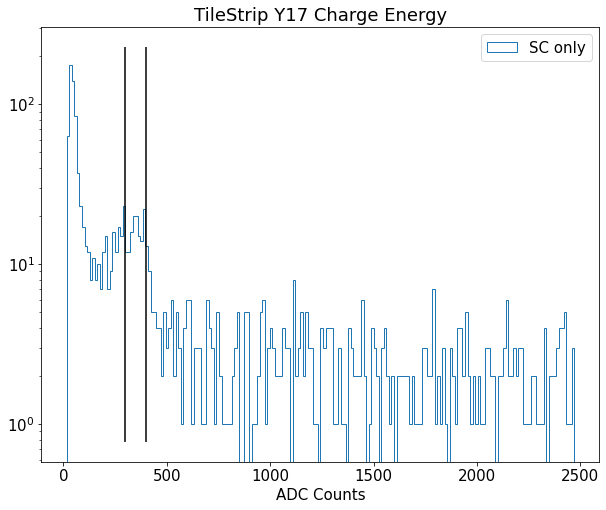

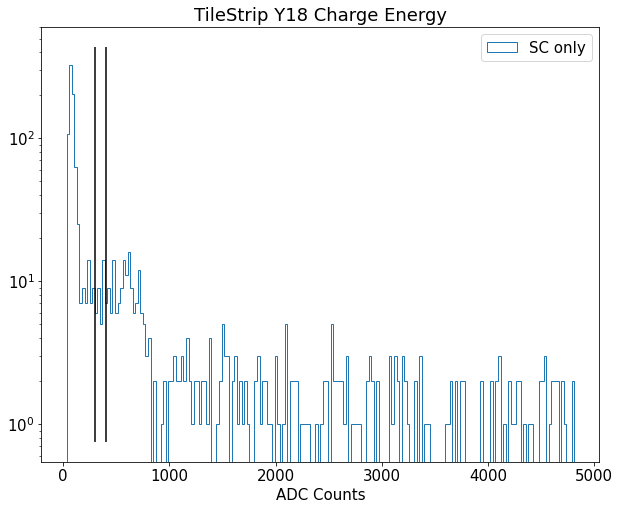

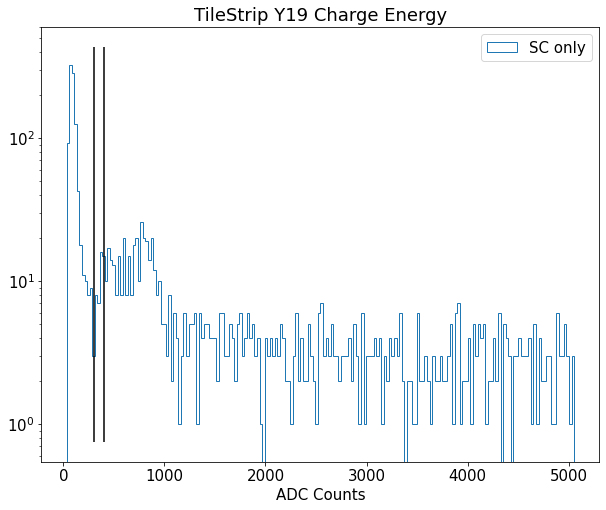

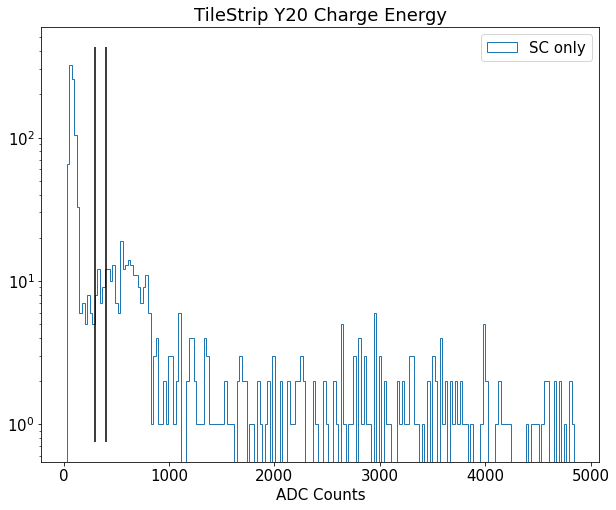

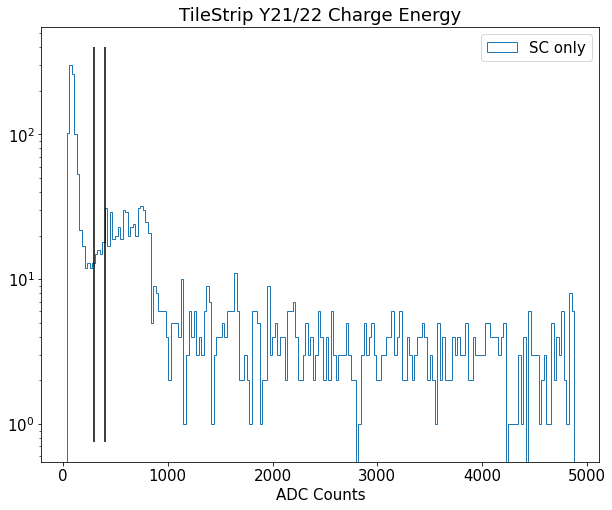

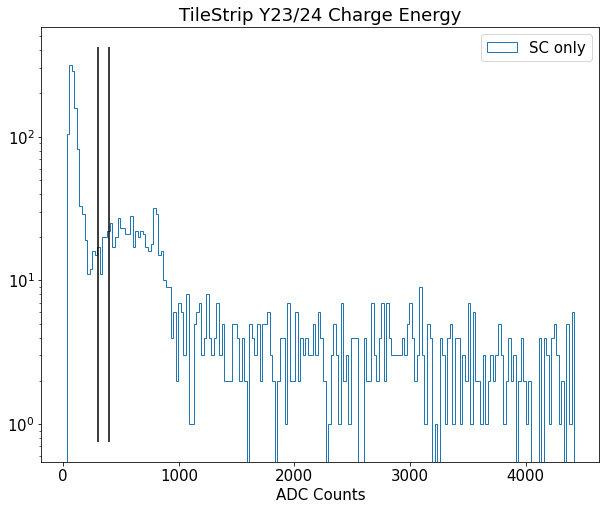

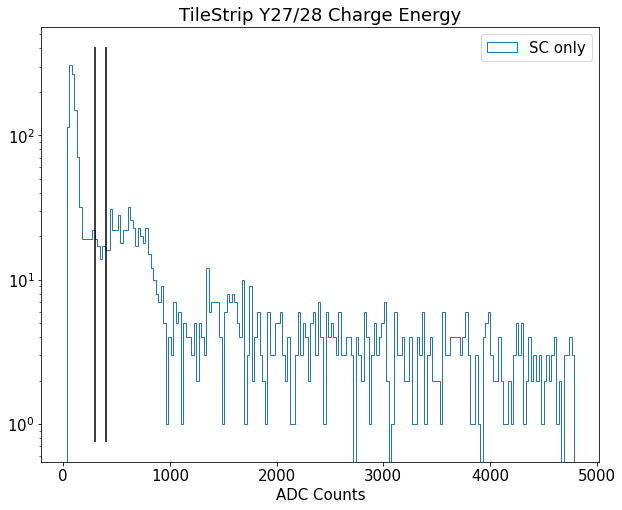

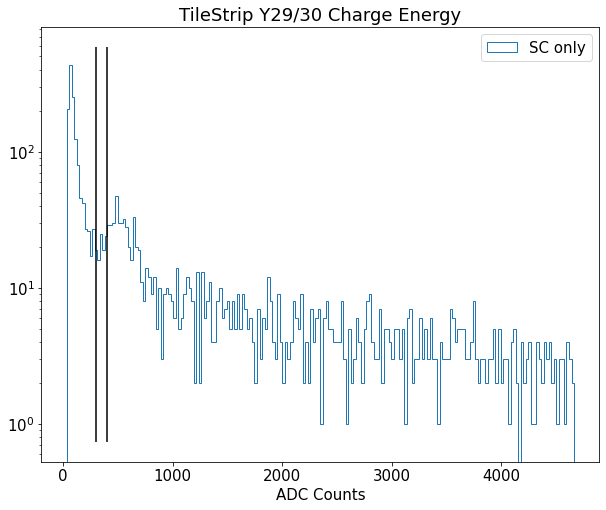

In [11]:
en_cut = [300,400]
out_df = pd.DataFrame()
i = 0
charge_min = 0
charge_max = 5000
#mask_energy = np.logical_and(df['Purity-Corrected Charge Energy']>600,df['Purity-Corrected Charge Energy']<800)
#mask = np.logical_and(mask_energy,mask_time)
mask = (DriftTime>20) & (DriftTime<60)
cross_cal = pd.DataFrame(columns=['channel','index'])
first = True
for k in df.keys():
    bins = 200
    if not (k.startswith('TileStrip') and k.endswith('Charge Energy')):
        continue
    uncal_channel_energy = df[k]/analysis_config.calibration_constants['Calibration'][i]
    purity_cor_uncal_channel_energy = uncal_channel_energy * np.exp(DriftTime/popt_e[1])
    
    mask_SC  = mask & (df[k] * np.exp(DriftTime/popt_e[1])>charge_min) & (df[k] * np.exp(DriftTime/popt_e[1])<charge_max) &\
    (df['TotalSiPMEnergy']>500000)
    mask_alpha  = np.logical_and(mask_SC,df[k] * np.exp(DriftTime/popt_e[1])>0.95*df['TotalTileEnergy'] * np.exp(DriftTime/popt_e[1]))
    if 'X19' in k:
        bins = 600
    try:
        #h,b,_ = plt.hist(purity_cor_uncal_channel_energy[mask_SC],bins=bins,histtype='step',\
        #         label='No multiplicity cut')
        h,b,_ = plt.hist(purity_cor_uncal_channel_energy[mask_alpha],bins=bins,histtype='step',\
                 label='SC only',log=True)
        out_series = pd.Series(data={'bins':b, 'value':h, 'index':df.loc[mask_alpha].index.tolist()}, name=k[10:-14])
        out_df = out_df.append(out_series, ignore_index=False)
    except ValueError:
        plt.hist(purity_cor_uncal_channel_energy[mask],bins=bins,histtype='step',label='null histogram',range=(100,800))
    plt.vlines(en_cut,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1])
    plt.xlabel('ADC Counts')
    plt.title(k)
    plt.legend()
    plt.show()
    i += 1
#out_df.to_pickle(folder.split('/')[0] +'_alpha_calibration.p' )

from scipy.ndimage import gaussian_filter
from TMSAnalysis.WaveformAnalysis import Waveform
import uproot
plt.rcParams['figure.figsize'] = [16, 12.8]
plt.rcParams['font.size'] = 15

run_parameters_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Run_Parameters_Run30.xlsx'
calibrations_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Calibrations_Xe_Run11b.csv'
channel_map_file = '/g/g90/jacopod/software/TMSAnalysis/config/30th/Channel_Map_Run30.xlsx'
for ev in alpha_df.loc[cut_ix].index:
    channel_number = analysis_config.GetNumberOfChannels()
    #event = Waveform.Event(path_to_reduced + folder + '/reduced_added.p',\
    #                       path_to_reduced + folder.split('/')[0] + '/raw_data',ev,\
    #                       run_parameters_file,\
    #                       calibrations_file,\
    #                       channel_map_file)

        
    fname = alpha_df['File'][ev]
    evt = alpha_df['Event'][ev]
    tier1_tree = uproot.open('{}{}'.format(path_to_reduced + folder.split('/')[0] + '/raw_data/',fname))['HitTree']
    tier1_ev = tier1_tree.arrays( entrystart=evt*channel_number, entrystop=(evt+1)*channel_number)
    global software_channel 
    software_channel = tier1_ev[b'_slot']*16+tier1_ev[b'_channel']
    if analysis_config.run_parameters['Sampling Rate [MHz]'] == 62.5:
        polarity = 1.

    waveform = np.array(tier1_ev[ b'_waveform'])
    wfm = {}
    #looping through channels and fill the waveforms
    for i,ch_waveform in enumerate(waveform):
        ch_type = analysis_config.GetChannelTypeForSoftwareChannel(software_channel[i])
        ch_name = analysis_config.GetChannelNameForSoftwareChannel(software_channel[i])
        if ch_name == 'Off':
            continue
        wfm[ch_name] = Waveform.Waveform(input_data = gaussian_filter( ch_waveform, 31),\
                                     detector_type       = ch_type,\
                                     sampling_period_ns  = 16.0,\
                                     input_baseline      = -1,\
                                     polarity            = polarity,\
                                     fixed_trigger       = False,\
                                     trigger_position    = analysis_config.run_parameters['Pretrigger Length [samples]'],\
                                     decay_time_us       = analysis_config.GetDecayTimeForSoftwareChannel( software_channel[i] ),\
                                     calibration_constant = analysis_config.GetCalibrationConstantForSoftwareChannel(software_channel[i]))
    ch_offset = 250
    for j in software_channel:
        v = analysis_config.GetChannelNameForSoftwareChannel(j)
        try:
            if analysis_config.GetChannelTypeForSoftwareChannel(j) == 'SiPM':
                suffix = 'Pulse Area'
            elif analysis_config.GetChannelTypeForSoftwareChannel(j) == 'Trigger':
                continue
            else:
                suffix = 'Charge Energy'
            plt.plot(np.arange(len(wfm[v].data))/62.5,wfm[v].data-np.mean(wfm[v].data[:2000])+ch_offset*j)
            en = alpha_df['{} {} '.format(analysis_config.GetChannelTypeForSoftwareChannel(j),analysis_config.GetChannelNameForSoftwareChannel(j)) + suffix][ev]
            plt.text(0,ch_offset*j,'{} {:.1f}'.format(v,en))
        except IndexError:
            continue
    plt.vlines(100,plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],linestyle='dashed')
    plt.xlabel('time [$\mu$s]')
    plt.title('Event {}, Energy {:.1f} ADC counts'.format(evt,alpha_df['TotalTileEnergy'][ev] * np.exp(DriftTime[ev]/popt_e[1])))
    plt.show()